In [1]:
!pip install timm

     |████████████████████████████████| 376 kB 626 kB/s 


In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from PIL import Image 
import cv2, json, pickle, os, time
from tqdm import tqdm 
import gc 
# import wandb
# from kaggle_secrets import UserSecretsClient
from statistics import mean 

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold 

import torch 
import torch.nn as nn 
import timm 
from torchvision import transforms
import albumentations as A 
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader

# Setup tools 

In [3]:
# user_secrets = UserSecretsClient()
# wandb_api = user_secrets.get_secret("wandb_api") 
# wandb.login(key=wandb_api)

In [4]:
config = dict(
    competition = "PetFinder", 
    device = "cuda:0" if torch.cuda.is_available() else "cpu", 
    batch_size = 64, 
    epoch = 200, 
    lr = 1e-4, 
    num_workers = 4, 
    infra = "kaggle", 
    model_name = "resnet34", 
    n_fold = 5, 
    project = "PetFinder", 
    group = "resnet34", 
    mode = "base_train", 
    debug = False, 
    seed = 42, 
    img_size = 256
)

# run = wandb.init(project="PetFinder", 
#           config=config, 
#           group="resnet34",
#           job_type="train")


In [5]:
if config["debug"]:
    train = pd.read_csv("../input/petfinder-pawpularity-score/train.csv", nrows=1000)
    test = pd.read_csv("../input/petfinder-pawpularity-score/test.csv", nrows=1000)
else:
    train = pd.read_csv("../input/petfinder-pawpularity-score/train.csv")
    test = pd.read_csv("../input/petfinder-pawpularity-score/test.csv")

train.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


# Fold split 

In [6]:
train["img_file"] = [f"../input/petfinder-pawpularity-score/train/{f}.jpg" for f in train.Id]
test["img_file"] = [f"../input/petfinder-pawpularity-score/test/{f}.jpg" for f in test.Id]

def k_split(train):
    kf = StratifiedKFold(n_splits=config["n_fold"], random_state=config["seed"])
    train["n_bins"] = pd.cut(train.Pawpularity, labels=False, bins=5)
    for i, (tr_idx, va_idx) in enumerate(kf.split(train, train.n_bins)):
        train.loc[va_idx, "fold"] = int(i)
    train.drop("n_bins", axis=1, inplace=True)
    train["fold"] = train.fold.astype(np.uint8)
    return train 

train = k_split(train)
train.head()

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,img_file,fold
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,../input/petfinder-pawpularity-score/train/000...,0
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,../input/petfinder-pawpularity-score/train/000...,0
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,../input/petfinder-pawpularity-score/train/001...,0
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,../input/petfinder-pawpularity-score/train/001...,0
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,../input/petfinder-pawpularity-score/train/001...,0


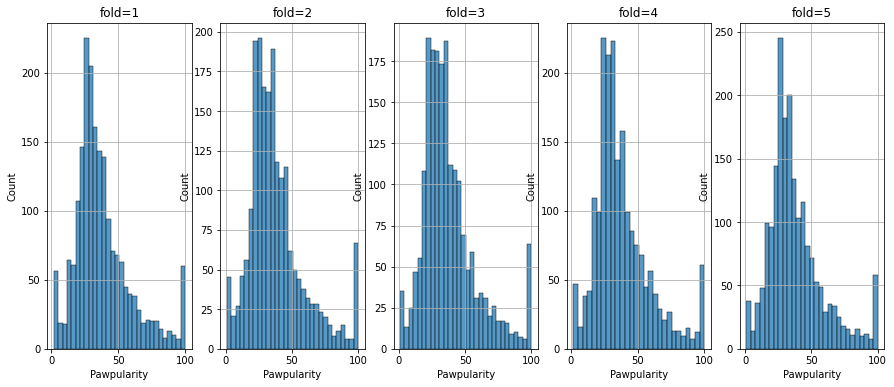

In [7]:
plt.figure(figsize=(15, 6))
for i in range(config["n_fold"]):
    plt.subplot(1, 5, i+1)
    sns.histplot(train.loc[train.fold == i, "Pawpularity"])
    plt.grid()
    plt.title(f"fold={i+1}")

# Dataset

In [8]:
class PedfinerDataset(Dataset):
    def __init__(self, df, is_train=True):
        self.df = df.reset_index(drop=True)
        self.is_train = is_train 
        
        if is_train:
            self.trans = A.Compose([
                A.Resize(config["img_size"], config["img_size"]), 
                A.HorizontalFlip(p=0.5), 
                A.ChannelShuffle(p=0.5), 
                A.HueSaturationValue(p=0.25),
                A.RandomBrightnessContrast(p=0.25),
                A.RandomGamma(p=0.25),
                A.Sharpen(p=0.25),
                ToTensorV2()
            ])
        else:
            self.trans = A.Compose([
                A.Resize(config["img_size"], config["img_size"]),
                ToTensorV2()
            ])
            
    def decode_img(self, img_f):
        img = cv2.imread(img_f)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.trans(image=img)
        img = img["image"] 
        img = torch.tensor(img, dtype=torch.float32) / 255.0
        return img
        
    
    def __getitem__(self, idx):
        df = self.df.iloc[idx]
        img_f = df["img_file"]
        img = self.decode_img(img_f)
        
        annt = df[1:13].astype(np.float32).ravel() # annotation
        annt = torch.tensor(annt, dtype=torch.float32)
        
        if self.is_train:
            label = df["Pawpularity"].astype(np.float32)
            lable = torch.tensor(label).float
            return img, annt, label 
        else:
            return img, annt 
        
    def __len__(self):
        return self.df.shape[0]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


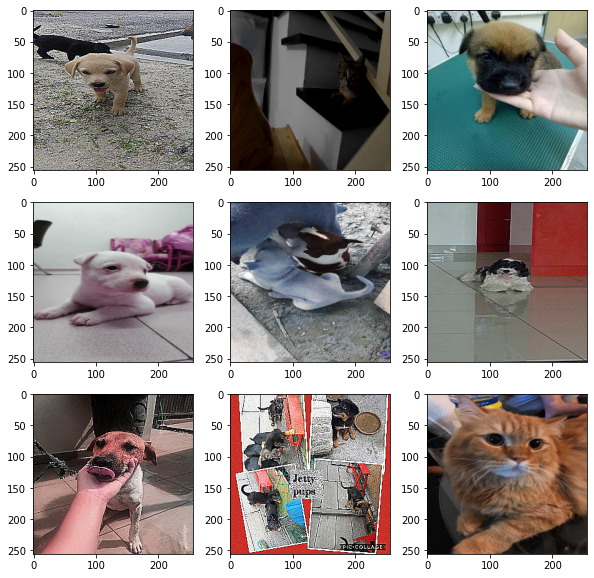

In [9]:
a = PedfinerDataset(train)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
ax = axes.ravel()
for i in range(9):
    ax[i].imshow(a[i][0].permute(1, 2, 0))

# Model 

In [10]:
class PedfinerModel(nn.Module):
    def __init__(self, input_annt_size=12, out_size=1):
        super(PedfinerModel, self).__init__()
        base_model = timm.create_model(config["model_name"], pretrained=True, in_chans=3)
        m = list(base_model.children())
        last_size = m[-1].in_features
        self.cnn = nn.Sequential(*m[:-1])
        for name, weight in self.cnn.named_parameters():
            if name.find("7.2") == 0:
                weight.requires_grad = True 
            else:
                weight.requires_grad = False 
        
        self.i2o = self.fc2normRelu(input_annt_size, input_annt_size)
        self.o2o = self.fc2normRelu(input_annt_size+last_size, out_size)
        
    def fc2normRelu(self, input_size, out_size):
        layer = []
        layer.append(nn.Linear(input_size, input_size))
        layer.append(nn.ReLU(inplace=True))
        layer.append(nn.Dropout(p=0.2))
        layer.append(nn.Linear(input_size, out_size))
        layer.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layer)
        
        
    def forward(self, img, annt):
        img_out = self.cnn(img) # -> (b, 512)
        ann_out = self.i2o(annt) # -> (b, 12)
        out = torch.cat((img_out, ann_out), dim=-1)
        out = self.o2o(out)
        return out # -> (b, 1)
    

# Train 

In [11]:
def train_batch(dl, net, criterion, optimizer, is_train=True):
    if is_train:
        net.train()
    else:
        net.eval()
    losses = []
    predict, correct = [], []
    for img, annt, label in tqdm(dl):
        img = img.to(config["device"])
        annt = annt.to(config["device"])
        label = label.to(config["device"])
        
        if is_train:
            out = net(img, annt)
            loss = criterion(out.squeeze(), label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                out = net(img, annt)
                loss = criterion(out.squeeze(), label)
                
        for o in out.view(-1).detach().cpu().numpy().tolist():
            predict.append(o)
        for c in label.detach().cpu().numpy().tolist():
            correct.append(c)
        losses.append(loss.item())
        del loss, img, annt, label 
    rmse = metrics(predict, correct)
    return mean(losses), rmse 
                
    
def train_epoch(train_dl, val_dl, fold):
    net = PedfinerModel()
    net.to(config["device"])
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=config["lr"])
    best_net, best_val_loss, best_e = None, np.inf, 0  
    tr_loss, va_loss, total_rmse = [], [], []
    for e in range(2):
        loss_tr, _ = train_batch(train_dl, net, criterion, optimizer)
        loss_va, rmse = train_batch(val_dl, net, criterion, None, is_train=False)
        
        if best_val_loss > loss_va:
            best_net = net 
            best_val_loss = loss_va 
            best_e = e 
        tr_loss.append(loss_tr)
        va_loss.append(loss_va)
        total_rmse.append(rmse)
        
        print(f"Fold:{fold} | Epoch:{e} | tr_Loss:{loss_tr:.3f} | va_Loss:{loss_va:.3f}| rmse: {rmse:.3f}")

        if e%10 == 0:
            checkpoint(net, fold, e)
        
    show_loss(tr_loss, va_loss, fold)
    checkpoint(best_net, fold, "best")
#     logger(fold, tr_loss, va_loss, total_rmse, best_val_loss, best_e)
    
def train_fold(train):
    for fold in range(config["n_fold"]):
        train_ds = PedfinerDataset(train[train.fold != fold])
        val_ds = PedfinerDataset(train[train.fold == fold])
        train_dl = DataLoader(train_ds,
                              batch_size=config["batch_size"], 
                              shuffle=True,
                              drop_last=True,
                              num_workers=config["num_workers"],
                              pin_memory=True)
        val_dl = DataLoader(val_ds,
                            batch_size=config["batch_size"], 
                            shuffle=True,
                            drop_last=True,
                            num_workers=config["num_workers"],
                            pin_memory=True)
        train_epoch(train_dl, val_dl, fold)
    torch.cuda.empty_cache()
    gc.collect()
    
def metrics(corr, pred):
    error = mean_squared_error(pred, corr)
    return error 
    
def logger(fold, tr_loss, va_loss, rmse, best_loss, e):
    wandb.log({
        "fold": fold, 
        "tr_loss": tr_loss, 
        "va_loss": va_loss, 
        "rmse": rmse, 
        "best_loss": best_loss,
        "best_epoch": e
    })
    
    
def checkpoint(net, fold, e):
    os.makedirs(f"models/{fold}", exist_ok=True)
    torch.save(net.state_dict(), f"models/{fold}/{e}.pth")
#     artifact = wandb.Artifact(name=config["model_name"], type='model')
#     artifact.add_file(f'models/{fold}/{e}.pth')
#     run.log_artifact(artifact)
    
    
def show_loss(tr, va, fold):
    plt.figure(figsize=(15, 6))
    plt.plot(np.arange(len(tr)).tolist(), tr, c="r")
    plt.plot(np.arange(len(va)).tolist(), va, c="b")
    plt.legend(["Train", "Val"])
    plt.grid()
    plt.title(f"Fold={fold}")
    plt.show()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet34-43635321.pth" to /root/.cache/torch/hub/checkpoints/resnet34-43635321.pth
  0%|          | 0/123 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Fold:0 | Epoch:0 | tr_Loss:876.850 | va_Loss:360.245| rmse: 360.245


  0%|          | 0/123 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

Fold:0 | Epoch:1 | tr_Loss:342.402 | va_Loss:364.476| rmse: 364.476


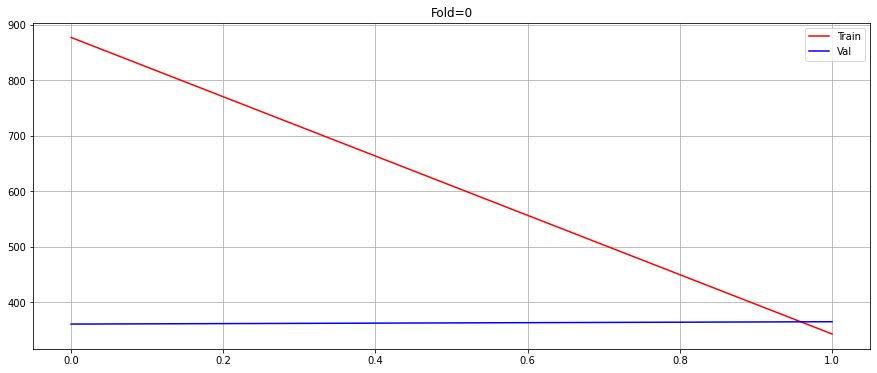

  0%|          | 0/123 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

Fold:1 | Epoch:0 | tr_Loss:957.913 | va_Loss:391.325| rmse: 391.325


  0%|          | 0/123 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

Fold:1 | Epoch:1 | tr_Loss:335.088 | va_Loss:369.389| rmse: 369.389


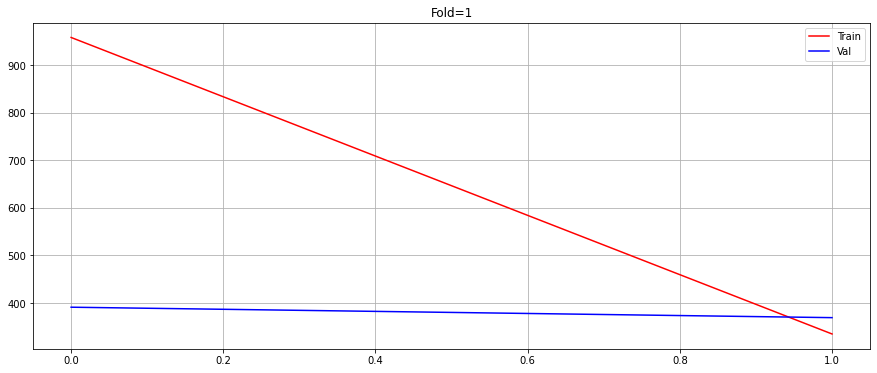

  0%|          | 0/123 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

Fold:2 | Epoch:0 | tr_Loss:944.353 | va_Loss:361.803| rmse: 361.803


  0%|          | 0/123 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

Fold:2 | Epoch:1 | tr_Loss:344.235 | va_Loss:345.124| rmse: 345.124


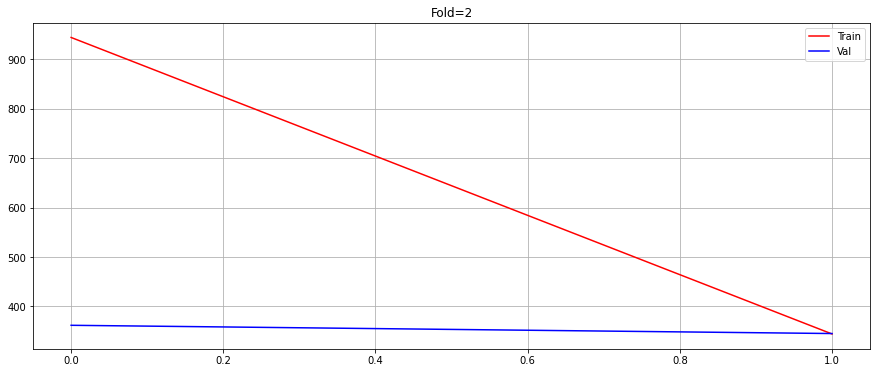

  0%|          | 0/123 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

Fold:3 | Epoch:0 | tr_Loss:934.785 | va_Loss:384.701| rmse: 384.702


  0%|          | 0/123 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

Fold:3 | Epoch:1 | tr_Loss:343.459 | va_Loss:354.078| rmse: 354.078


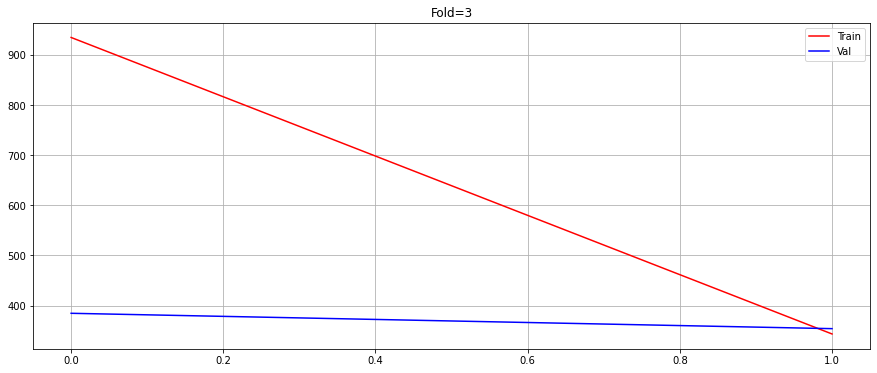

  0%|          | 0/123 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

Fold:4 | Epoch:0 | tr_Loss:928.899 | va_Loss:378.919| rmse: 378.919


  0%|          | 0/123 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTen

Fold:4 | Epoch:1 | tr_Loss:340.738 | va_Loss:353.046| rmse: 353.046


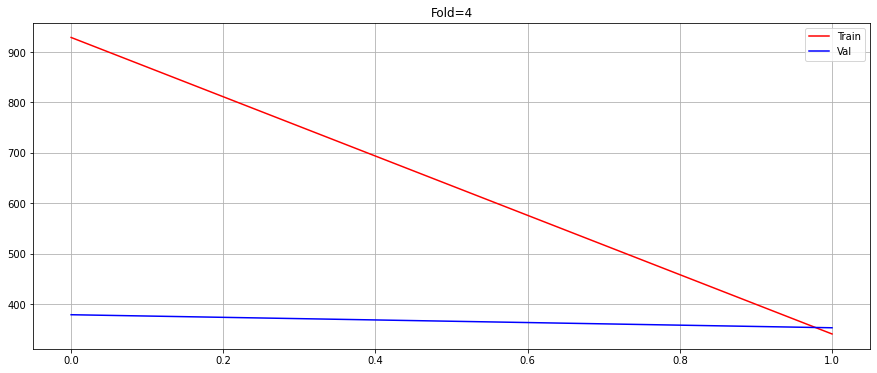

In [12]:
train_fold(train)

In [13]:
def load_net(fold):
    net = PedfinerModel()
    if config["debug"] is not True:
        net.load_state_dict(torch.load(f"models/{fold}/best.pth", map_location={"cuda:0" : "cpu"}))
    net.eval()
    net.to(config["device"])
    return net 

def test_batch(dl, fold):
    net = load_net(fold)
    predict = []
    for img, annt in tqdm(dl):
        img = img.to(config["device"])
        annt = annt.to(config["device"])
        
        with torch.no_grad():
            out = net(img, annt)
            out = out.squeeze().detach().cpu().numpy().tolist()
            
            for o in out:
                predict.append(o)
    return np.array(predict)
            

def inference(test):
    for fold in range(config["n_fold"]):
        test_ds = PedfinerDataset(test, is_train=False)
        test_dl = DataLoader(test_ds,
                             batch_size=config["batch_size"], 
                             shuffle=False,
                             drop_last=False)
        pred = test_batch(test_dl, fold)
    
    return np.mean(pred, axis=0).tolist()


def log_wandb():
    artifact = wandb.Artifact(name=config["model_name"], type='submit')
    artifact.add_file(f'submission.csv')
    run.log_artifact(artifact)

def submit(test):
    pred = inference(test)
    sub = pd.read_csv("../input/petfinder-pawpularity-score/sample_submission.csv")
    sub["Pawpularity"] = pred 
    sub.to_csv("submisstion.csv", index=False)
#     try:
#         log_wandb()
#     except Exception as e:
#         print("error ...")
        
    
    

In [14]:
submit(test)

100%|██████████| 1/1 [00:00<00:00, 18.26it/s]
